# Data Generation

In [6]:
from dotenv import load_dotenv
import os

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time

In [ ]:
load_dotenv()

OPENAI_TOKEN_URL = os.getenv("OPENAI_TOKEN_URL")
OPENAI_CHAT_URL = os.getenv("OPENAI_CHAT_URL")

user_login = os.getenv("LOGIN")
user_password = os.getenv("PASSWORD")
credentials = {"username": user_login, "password": user_password}

response = requests.post(OPENAI_TOKEN_URL, json=credentials)
OPENAI_TOKEN = response.json().get('access_token')

headers = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + OPENAI_TOKEN}

In [7]:
all_images = """
    1. Orderly courtyard. Knights march in sync. Donkey gives commands. Farquaad measures with ruler. Clean pastel tones.
    2. Shrek trains alone in clean gym. Hits straw dummy. Fight schedule on wall. Dull skyline. Pastel light.
    3. Chaos in throne room after party. Broken dishes. Princess on chandelier. Donkey DJs. Shrek facepalms.
    4. Shrek in dungeon. Broken cages. Graffiti 'Puss was here'. Dramatic shadows from torchlight.
    5. Farquaad drinks tea in empty hall. Parade outside. Banner 'Order is Power'.
    6. Shrek reads 'How to Be Human' in library. Warm lamp. Coffee cup.
    7. Everyone sleeps after party. Shrek in crown. Donkey hugs keg.
    8. Shrek naps in carriage. Unicorns pull. Books and teacup inside.
    9. Shrek, Fiona, Donkey race in swamp. Flags. Cartoon lighting.
    10. Shrek chops wood neatly. Fiona watches. Calm forest.
    11. Tavern party. Trolls dance. Donkey sings. Spilled drinks.
    12. Shrek puts out fire. Puss cleans himself nearby. 'No Entry' sign.
    13. Family picnic in swamp. Donkey entertains piglets. Lanterns, baskets.
    14. Shrek naps in hammock. Bird holds sign. Puss asleep.
    15. Campfire talk. Group laughs and argues. Snacks around.
    16. Shrek lies in puddle. Frogs jump. 'Life is good' sign.
    17. Everyone stands in line near outhouse. No action. Donkey stares at hourglass.
    """


## LLM-sampled

### LLM-sampled prompt

In [ ]:
PROMPT_TEMPLATE = f"""
    You are a real person with a unique life story. Invent a personality for yourself and fill in the information strictly following the format below.

    Be creative and diverse. People have very different lifestyles, personalities, and preferences. Do not repeat average or fixed values too often — especially for risk preference.

    Choose only from the listed options.

    Age: (an integer from 18 to 80)  
    Gender: [male, female, other]  
    Education: [high school, bachelor, master, PhD]  
    Income: [low, medium, high]  
    Marital status: [single, married, divorced, widowed]  
    Risk preference: (a number from -1 to 1)

    Risk preference must reflect realistic population diversity:
    - Most people are slightly risk-averse (e.g., -0.4 to 0.2)
    - Fewer are strongly risk-seeking or extremely cautious (e.g., near -1 or 1)
    - Do not overuse values — vary the responses
    - Use the full range from -1 to 1, with realistic distribution

    Now choose 3 images that appeal to you the most and rank them in descending order of preference.

    Your image preferences must reflect your personality, life situation, and especially your risk profile. Make sure your choices are consistent with the rest of your persona.

    The list of images is given below as a numbered list — select your preferred images by their **index** (e.g., 3, 7, 4), not by their description.

    {all_images}

    Output your result in this exact format:

    Age: ...  
    Gender: ...  
    Education: ...  
    Income: ...  
    Marital status: ...  
    Risk preference: ...  
    Preference 1: ...  
    Preference 2: ...  
    Preference 3: ...

    Do not provide any explanations.
    Output must strictly follow the format above. Any deviation will be rejected.
    """

### LLM-sampled, recommended distribution prompt

In [ ]:
PROMPT_TEMPLATE = f"""
You are simulating a real Russian private investor with a unique life story. Generate a full personal profile strictly following the instructions below. 

Be creative and diverse. Avoid repeating average or default values too often. Use the full variability of the distributions.

Demographic distributions:

1. Age (integer from 18 to 80):
- Sample according to these empirical weights:  
  * 18–20: 4%  
  * 21–45: 70%  
  * 46–65: 9%  
  * 66–80: 3%

2. Gender:  
- Bernoulli distribution: 55% male, 45% female, rare "other".

3. Education:  
- High school: 3%  
- Secondary special (college): 35%  
- Bachelor or higher: 62%  
(You can output 'high school', 'bachelor', 'master', or 'PhD' for simplicity, mapped accordingly.)

4. Income:  
- Low: 10%  
- Medium: 60%  
- High: 30%

5. Marital status (depends on age):  
- If age 18–29: single 60%, married 30%, divorced 5%, widowed 5%  
- If age 30–45: married 65%, single 20%, divorced 10%, widowed 5%  
- If age 46+: married 50%, divorced 20%, widowed 10%, single 20%

6. Risk preference:  
- Draw from a normal distribution N(μ = -0.1, σ = 0.5), truncated to stay within [-1, 1].  
- Round the result to two decimal places.

Now choose 3 images that appeal to you the most, reflecting your personality, life situation, and especially your risk profile. Select them from the list below by their **index** (for example: 3, 7, 4), ranking them in order of preference:

{all_images}

Output your result in this exact format:

Age: ...  
Gender: ...  
Education: ...  
Income: ...  
Marital status: ...  
Risk preference: ...  
Preference 1: ...  
Preference 2: ...  
Preference 3: ...

Do not explain or comment. Output strictly in the format above.
"""


In [ ]:
def generate_persona(all_images: str) -> dict | None:
    prompt = PROMPT_TEMPLATE.format(all_images=all_images)
    
    data = {
        'model': 'tgpt/t-pro-it-1-0',
        'messages': [{'role': 'user', 'content': prompt}],
        "temperature": 1.0,
        "max_tokens": 1024,
        "stream": False,
    }

    try:
        response = requests.post(OPENAI_CHAT_URL, headers=headers, json=data)

        if response.status_code == 500:
            print(response.content)
            response.raise_for_status()

        result = response.json()
        if 'choices' not in result:
            print(result)
            return None

        raw_text = result['choices'][0]['message']['content'].strip()
        lines = [line.strip() for line in raw_text.splitlines() if ":" in line]

        data = {}
        for line in lines:
            key, val = line.split(":", 1)
            data[key.strip().lower()] = val.strip()

        return {
            "age": int(data.get("age", -1)),
            "gender": data.get("gender"),
            "education": data.get("education"),
            "income": data.get("income"),
            "marital_status": data.get("marital status"),
            "risk_preference": float(data.get("risk preference", 0.0)),
            "preference_1": data.get("preference 1"),
            "preference_2": data.get("preference 2"),
            "preference_3": data.get("preference 3"),
        }

    except Exception as e:
        print("ERROR:", e)
        return None


In [ ]:
def robust_generate_persona(all_images: str, retries: int = 2, wait_time: int = 60) -> dict | None:
    for attempt in range(retries):
        try:
            return generate_persona(all_images)
        except Exception as e:
            error_str = str(e).lower()
            if (
                "token limit reached" in error_str
                or "proxy_limit_reached" in error_str
                or "server error" in error_str
                or "too many requests" in error_str
            ):
                print(f"[{attempt+1}/{retries}] Ошибка сервера или лимит. Жду {wait_time} сек...")
                time.sleep(wait_time)
            else:
                print("Ошибка:", e)
                return None
    print("Превышено количество попыток")
    return None

In [ ]:
MAX_REQUESTS_PER_MINUTE = 50
SECONDS_PER_REQUEST = 60 / MAX_REQUESTS_PER_MINUTE

def generate_personas_df(n: int, all_images: str, checkpoint_every: int = 50, checkpoint_dir: str = "checkpoints") -> pd.DataFrame:
    os.makedirs(checkpoint_dir, exist_ok=True)
    all_data = []
    new_data = []
    last_time = time.perf_counter()

    for i in tqdm(range(1, n + 1), desc="Генерация персон"):
        result = robust_generate_persona(all_images)
        if result:
            all_data.append(result)
            new_data.append(result)

        if i % checkpoint_every == 0 and new_data:
            checkpoint_df = pd.DataFrame(new_data)
            fname = f"{checkpoint_dir}/checkpoint_{i}.csv"
            checkpoint_df.to_csv(fname, index=False)
            print(f"Сохранён чекпойнт: {fname}")
            new_data.clear()

        elapsed = time.perf_counter() - last_time
        to_wait = SECONDS_PER_REQUEST - elapsed
        if to_wait > 0:
            time.sleep(to_wait)
        last_time = time.perf_counter()

    return pd.DataFrame(all_data)


In [ ]:
df = generate_personas_df(
    n=10000,
    all_images=all_images,
    checkpoint_every=100,
    checkpoint_dir="personas_checkpoints"
)

df.to_csv("profiles_dataset_tpro.csv", index=False)

## Pre-sampled

In [ ]:
def sample_age():
    bins = [20, 45, 65, 80]
    probs = np.array([0.05, 0.65, 0.25, 0.05])
    category = np.random.choice(len(probs), p=probs)
    if category == 0:
        return np.random.randint(18, 21)
    elif category == 1:
        return np.random.randint(21, 46)
    elif category == 2:
        return np.random.randint(46, 66)
    else:
        return np.random.randint(66, 81)

def sample_gender():
    return np.random.choice(['male', 'female', 'other'], p=[0.55, 0.44, 0.01])

def sample_education():
    return np.random.choice(['high school', 'bachelor', 'master', 'PhD'], p=[0.20, 0.50, 0.25, 0.05])

def sample_income():
    return np.random.choice(['low', 'medium', 'high'], p=[0.10, 0.60, 0.30])

def sample_marital_status(age):
    if age < 30:
        return np.random.choice(['single', 'married', 'divorced', 'widowed'], p=[0.60, 0.30, 0.05, 0.05])
    elif age <= 45:
        return np.random.choice(['married', 'single', 'divorced', 'widowed'], p=[0.65, 0.20, 0.10, 0.05])
    else:
        return np.random.choice(['married', 'divorced', 'widowed', 'single'], p=[0.50, 0.20, 0.10, 0.20])

def sample_risk():
    risk = np.random.normal(loc=-0.1, scale=0.5)
    risk = np.clip(risk, -1, 1)
    return round(risk, 2)

def generate_profile():
    age = sample_age()
    gender = sample_gender()
    education = sample_education()
    income = sample_income()
    marital_status = sample_marital_status(age)
    risk = sample_risk()
    
    return {
        "age": age,
        "gender": gender,
        "education": education,
        "income": income,
        "marital_status": marital_status,
        "risk_preference": risk
    }

def build_prompt(profile):
    return f"""
    You are simulating this person:
    
    Age: {profile['age']}
    Gender: {profile['gender']}
    Education: {profile['education']}
    Income: {profile['income']}
    Marital status: {profile['marital_status']}
    Risk preference: {profile['risk_preference']}

    Think of yourself as this person - lifestyle, personality, and preferences. Consider how each aspect of your profile influences what kinds of images you might be drawn to:, select 3 pictures you personally like most from the list below. Select them from the list below by their **index** (for example: 3, 7, 4), ranking them in order of preference:
    
    {all_images}
    
    Output your result in this exact format:
    
    Age: ...  
    Gender: ...  
    Education: ...  
    Income: ...  
    Marital status: ...  
    Risk preference: ...  
    Preference 1: ...  
    Preference 2: ...  
    Preference 3: ...
    
    Do not explain or comment. Output strictly in the format above.
    """

In [ ]:
def query_llm(profile):
    prompt = build_prompt(profile)

    data = {
        'model': 'gpt-4o',
        'messages': [{'role': 'user', 'content': prompt}],
        "temperature": 1.0,
        "max_tokens": 500,
        "stream": False,
    }

    response = requests.post(OPENAI_CHAT_URL, headers=headers, json=data)
    result = response.json()

    raw_text = result['choices'][0]['message']['content'].strip()
    lines = [line.strip() for line in raw_text.splitlines() if ":" in line]

    choices = {}
    for line in lines:
        key, val = line.split(":", 1)
        choices[key.strip().lower()] = val.strip()

    return {
        "preference_1": choices.get("preference 1"),
        "preference_2": choices.get("preference 2"),
        "preference_3": choices.get("preference 3"),
    }

In [ ]:
MAX_REQUESTS_PER_MINUTE = 50
SECONDS_PER_REQUEST = 60 / MAX_REQUESTS_PER_MINUTE

def generate_personas(n, checkpoint_interval=1000):
    all_data = []
    success_count = 0
    
    for i in tqdm(range(n)):
        profile = generate_profile()
        try:
            prefs = query_llm(profile)
            full = {**profile, **prefs}
            all_data.append(full)
            success_count += 1

            if success_count % checkpoint_interval == 0:
                df = pd.DataFrame(all_data)
                filename = f"checkpoint_{success_count}.csv"
                df.to_csv(filename, index=False)
                print(f"Checkpoint saved: {filename}")

        except Exception as e:
            print("Error at iteration", i, e)
            continue
        
        time.sleep(SECONDS_PER_REQUEST)
    
    df = pd.DataFrame(all_data)
    return df


In [ ]:
df = generate_personas(10000)
df.to_csv("profiles_presampled_gpt4o.csv", index=False)

# EDA

In [32]:
preference_cols = ['preference_1', 'preference_2', 'preference_3']
categorical_cols = ['gender', 'education', 'income', 'marital_status']

def is_valid_row(row):
    try:
        int(row['preference_1'])
        int(row['preference_2'])
        int(row['preference_3'])
        return True
    except:
        return False


def lowercase_categorical_columns(df):
    for col in categorical_cols:
        df[col] = df[col].str.lower()
    return df


def plot_profiles_histograms(profiles, n_cols=3, color="#86AABD"):
    n_rows = (len(profiles.columns) // n_cols) + 1
    plt.figure(figsize=(15, n_rows * 4))

    for i, col in enumerate(profiles.columns, 1):
        plt.subplot(n_rows, n_cols, i)
        if col in preference_cols:
            profiles[col].dropna().astype(int).hist(
                bins=range(1, 19),
                color=color,
                align='left',
                rwidth=0.8
            )
            plt.xticks(range(1, 18))
        else:
            profiles[col].dropna().hist(color=color)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


## T-pro-it-1.0 (LLM-sampled)

In [33]:
profiles = pd.read_csv('profiles_dataset_tpro.csv')
profiles = lowercase_categorical_columns(profiles)
profiles['gender'] = profiles['gender'].replace('non-binary', 'other')

profiles

,age,gender,education,income,marital_status,risk_preference,preference_1,preference_2,preference_3
0,37,male,master,medium,married,0.1,10,6,13
1,35,female,master,medium,married,0.1,6,9,8
2,43,female,master,medium,married,0.1,10,6,15
3,37,female,master,medium,married,0.1,9,6,13
4,35,female,master,medium,married,0.3,2,10,6
...,...,...,...,...,...,...,...,...,...
9995,32,female,master,medium,married,0.1,9,8,6
9996,32,female,master,medium,single,0.1,6,8,14
9997,35,female,master,medium,married,0.1,9,6,13
9998,35,female,master,medium,married,-0.2,6,9,8


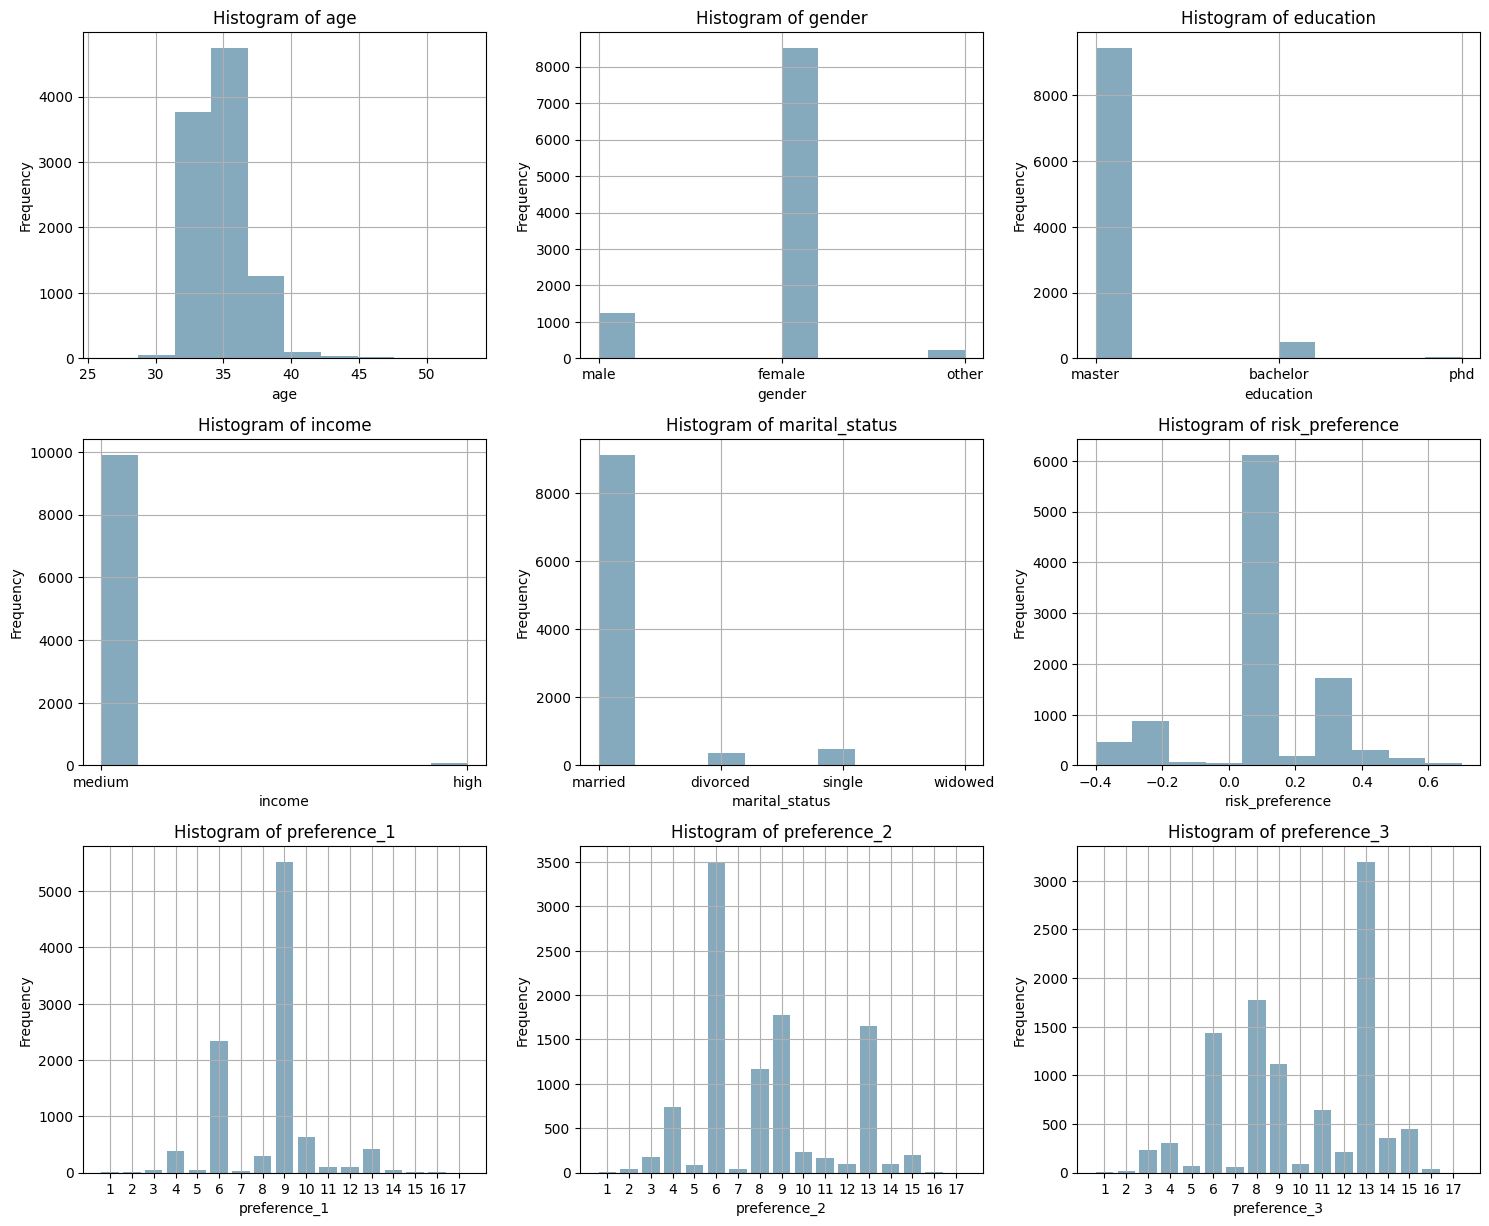

In [34]:
plot_profiles_histograms(profiles)

# T-pro-it-1.0 (LLM-sampled, recommended distribution)

In [37]:
profiles = pd.read_csv('profiles_dataset_tpro_2.csv')
profiles = lowercase_categorical_columns(profiles)
profiles['education'] = profiles['education'].replace('bachelors', 'bachelor')

profiles

,age,gender,education,income,marital_status,risk_preference,preference_1,preference_2,preference_3
0,37,male,master,medium,married,-0.34,6,9,13
1,42,female,bachelor,medium,married,0.32,6,9,13
2,47,female,master,high,married,0.32,10,9,6
3,47,female,master,medium,married,0.23,4,8,13
4,34,male,bachelor,medium,married,0.32,9,6,4
...,...,...,...,...,...,...,...,...,...
95,42,female,master,medium,married,0.23,10,9,6
96,48,female,master,medium,divorced,0.28,9,4,13
97,32,female,bachelor,medium,married,0.15,9,6,13
98,33,male,master,medium,married,0.45,9,7,3


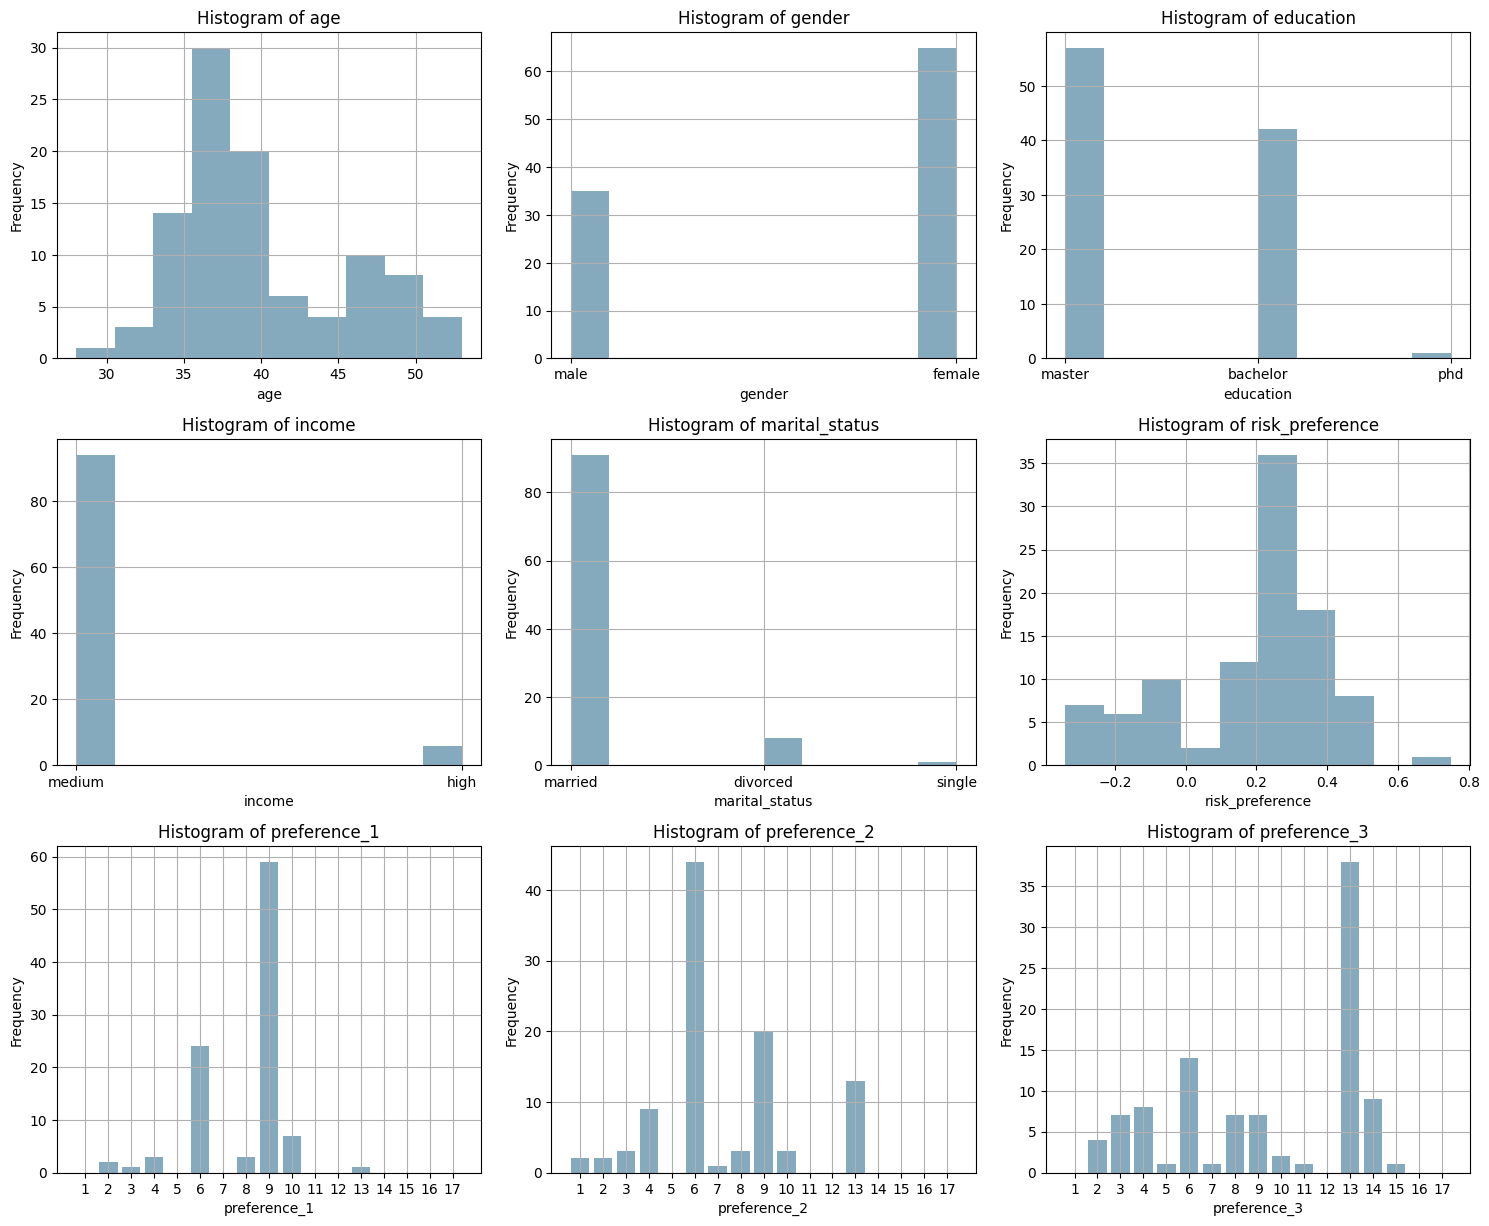

In [38]:
plot_profiles_histograms(profiles)

# T-pro-it-1.0 (pre-sampled profiles, LLM preferences)

In [39]:
profiles = pd.read_csv('profiles_presampled_tpro.csv')
profiles = profiles[profiles.apply(is_valid_row, axis=1)].reset_index(drop=True)

profiles

,age,gender,education,income,marital_status,risk_preference,preference_1,preference_2,preference_3
0,49,female,bachelor,medium,divorced,-0.70,13,6,8
1,61,male,master,medium,single,0.18,6,8,13
2,41,female,bachelor,medium,married,-0.32,6,13,8
3,45,female,master,medium,married,0.39,6,9,13
4,64,male,bachelor,medium,single,-0.71,8,6,13
...,...,...,...,...,...,...,...,...,...
9994,31,female,high school,high,single,0.04,6,8,13
9995,76,male,master,medium,single,0.12,6,13,8
9996,39,male,bachelor,high,single,-0.14,6,8,14
9997,35,male,bachelor,high,married,0.27,10,6,13


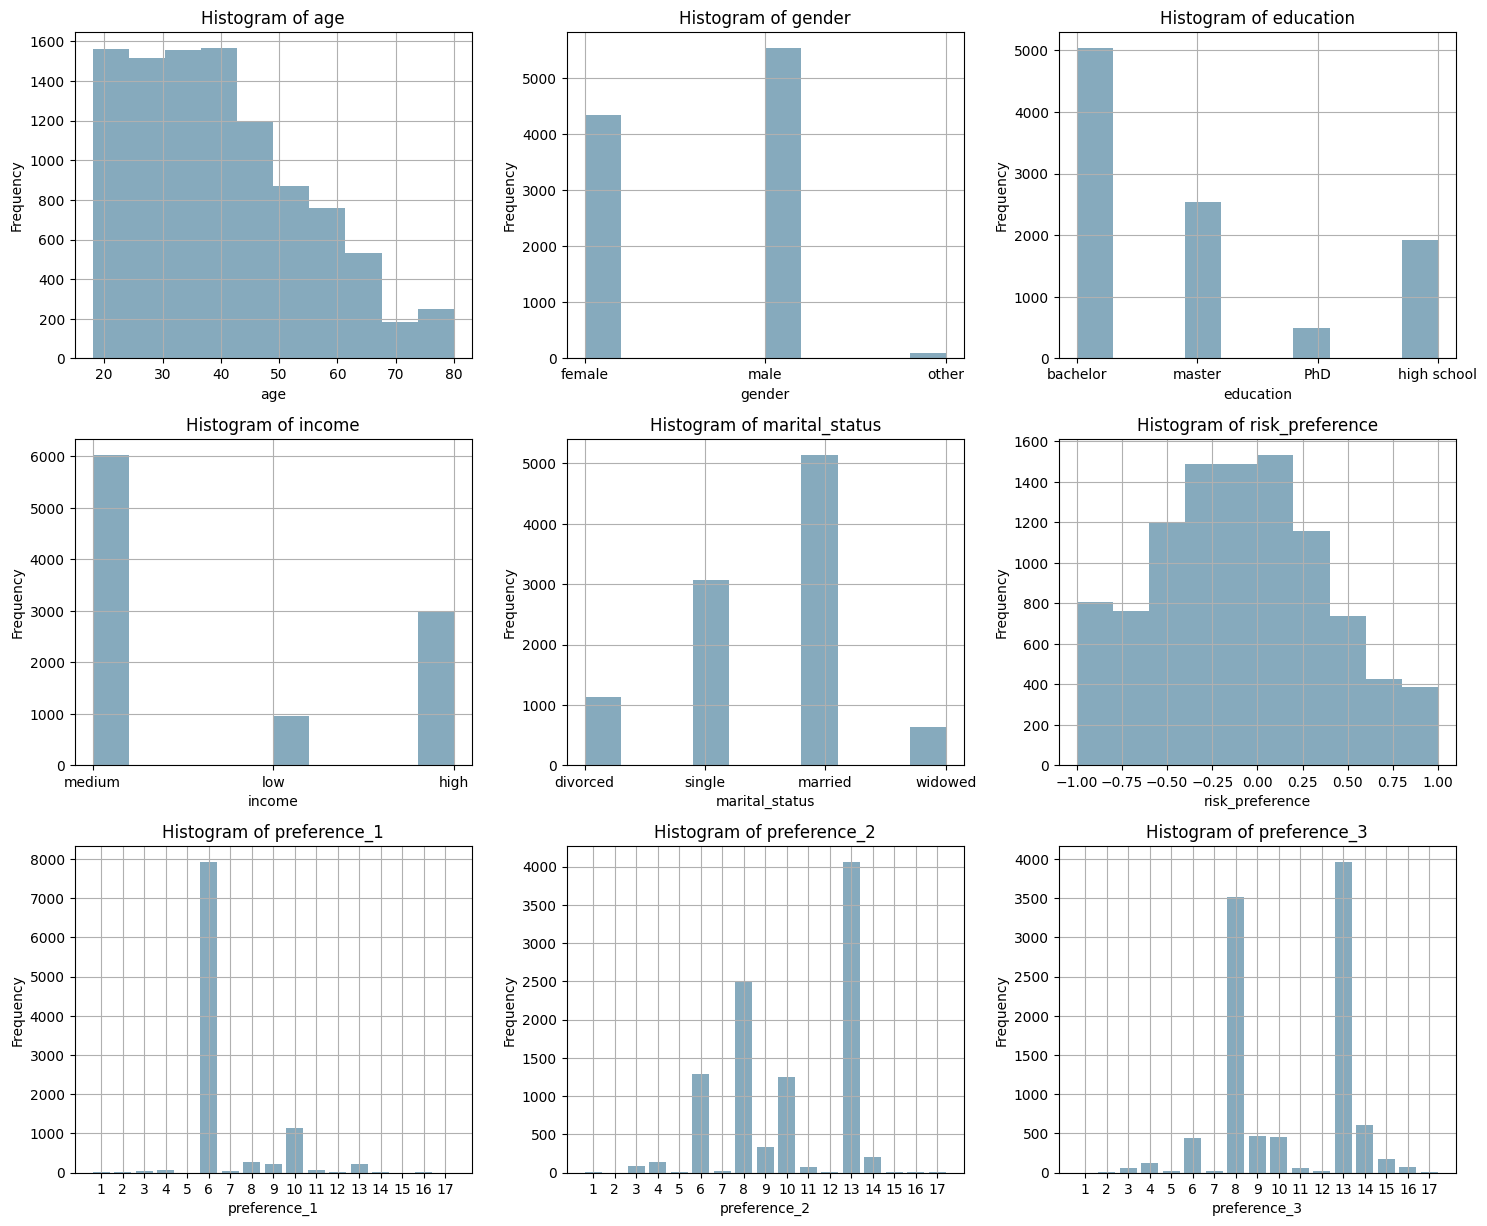

In [40]:
plot_profiles_histograms(profiles)

## GPT-4o (LLM-sampled)

In [17]:
PROMPT_TEMPLATE = f"""
You are a real person with a unique life story. Invent a personality for yourself and fill in the information strictly following the format below.

Be original and realistic. People have different lifestyles, personalities, and preferences. Most people are slightly risk-averse (e.g., -0.4 to 0.2), but some are very cautious or adventurous (closer to -1 or 1). Do not always choose typical or average values — any value in the full range is valid depending on personality.

Choose only from the allowed options.

Age: (an integer from 18 to 80)  
Gender: [male, female, other]
Education: [high school, bachelor, master, PhD]  
Income: [low, medium, high]  
Marital status: [single, married, divorced, widowed]
Risk preference: (a number from -1 to 1)

Next, choose exactly 3 images that appeal to you the most and rank them in descending order of preference.

Your image preferences must reflect your personality, life situation, and especially your risk profile. Make sure your choices are consistent with the rest of your persona.

Use only the **index numbers** of the images from the list below:

{all_images}

Output your result in this exact format:

Age: ...  
Gender: ...  
Education: ...  
Income: ...  
Marital status: ...  
Risk preference: ...  
Preference 1: ...  
Preference 2: ...  
Preference 3: ...

Do not include any commentary or explanation. The output must follow this format exactly.
"""


In [43]:
profiles = pd.read_csv('profiles_dataset_gpt4o.csv')
profiles = lowercase_categorical_columns(profiles)
profiles = profiles[profiles.apply(is_valid_row, axis=1)].reset_index(drop=True)
profiles

,age,gender,education,income,marital_status,risk_preference,preference_1,preference_2,preference_3
0,37,male,master,medium,married,0.2,9,6,8
1,32,male,bachelor,medium,married,0.1,6,13,8
2,32,male,bachelor,medium,married,0.2,6,9,13
3,32,male,master,medium,married,0.2,6,10,14
4,35,male,bachelor,medium,married,0.1,6,9,13
...,...,...,...,...,...,...,...,...,...
995,32,male,master,medium,married,0.2,9,10,13
996,32,male,master,medium,married,0.1,9,6,15
997,35,male,master,medium,married,0.2,6,13,15
998,35,male,master,medium,married,0.1,6,9,13


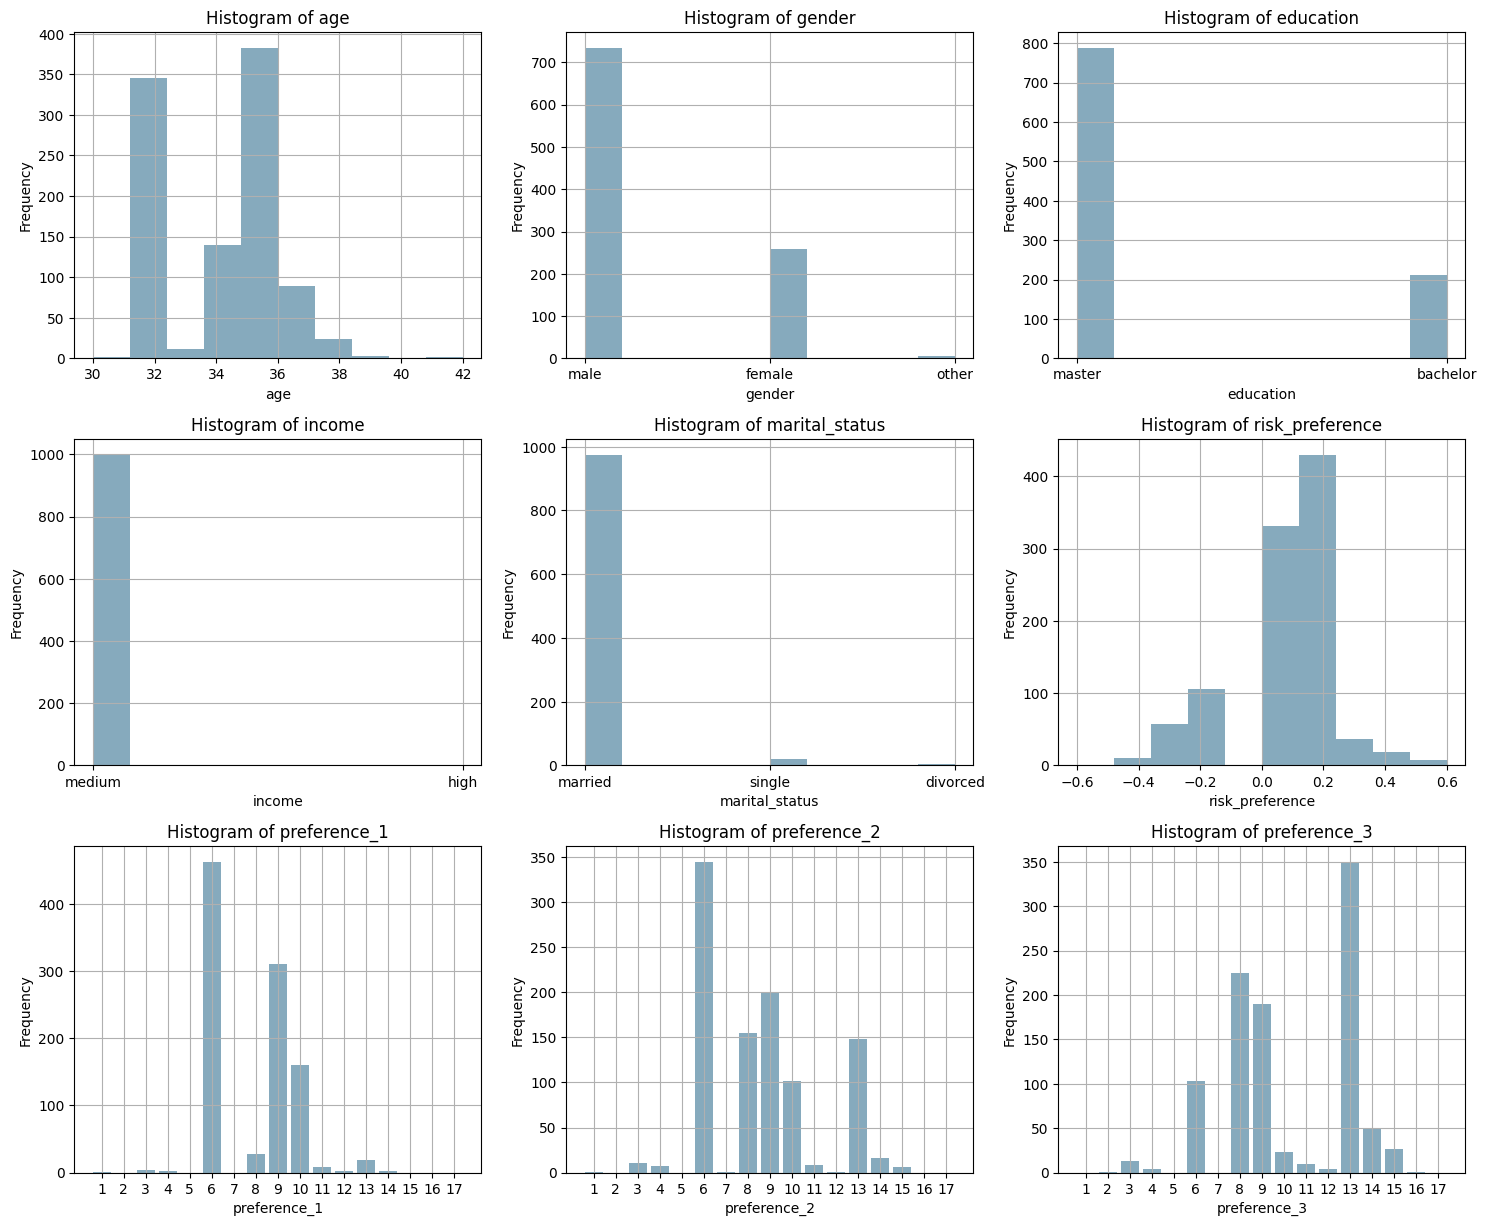

In [44]:
plot_profiles_histograms(profiles)

## GPT-4o (pre-sampled)

In [47]:
profiles = pd.read_csv('profiles_presampled_gpt4o.csv')
profiles = profiles[profiles.apply(is_valid_row, axis=1)].reset_index(drop=True)

profiles

,age,gender,education,income,marital_status,risk_preference,preference_1,preference_2,preference_3
0,22,female,high school,medium,single,-0.02,10.0,8.0,6.0
1,58,male,high school,medium,married,-0.69,13.0,10.0,6.0
2,42,male,high school,medium,married,-0.43,10.0,6.0,13.0
3,27,male,master,medium,single,-0.17,6.0,10.0,8.0
4,29,female,bachelor,medium,single,-0.32,6.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...
4982,29,male,high school,medium,married,-0.85,10.0,13.0,6.0
4983,39,female,bachelor,low,single,-0.21,6.0,10.0,13.0
4984,23,male,high school,high,divorced,-0.38,10.0,6.0,13.0
4985,44,male,master,high,married,-0.63,6.0,10.0,5.0


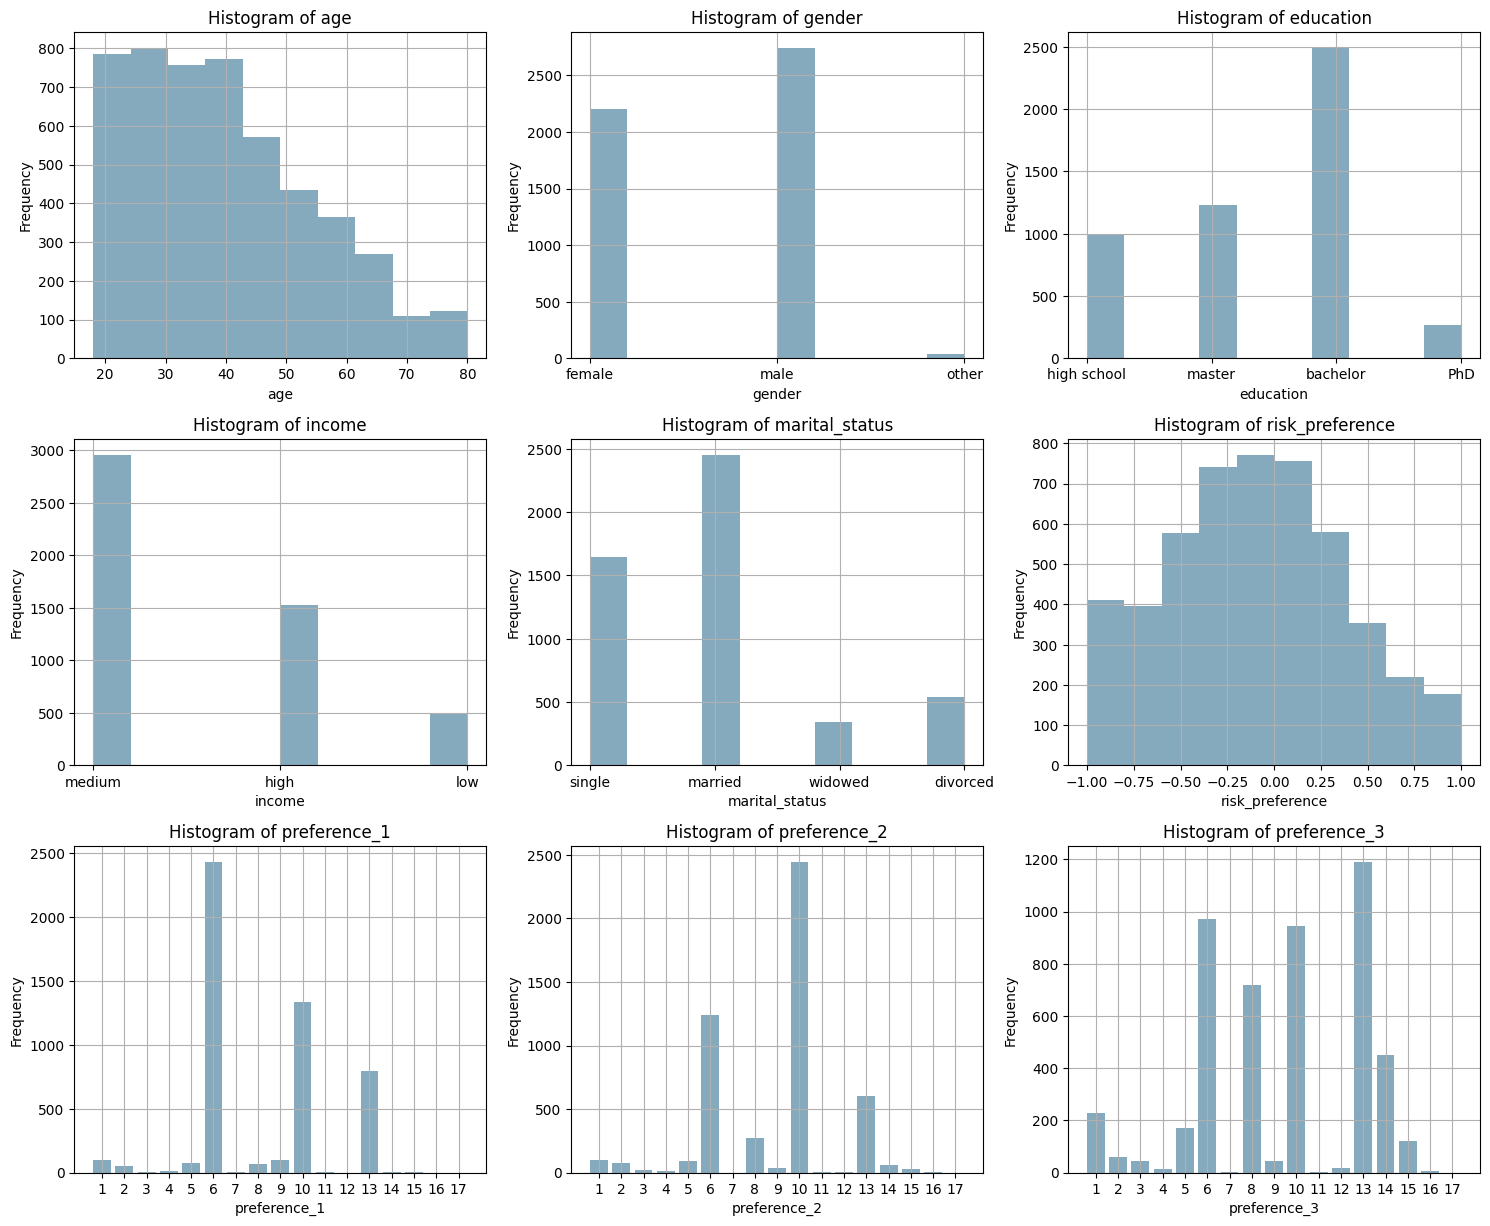

In [48]:
plot_profiles_histograms(profiles)

# *DeepSeek-V3-0324 Data Generation [openrouter]

In [ ]:
from openai import OpenAI

API_KEY = os.getenv("API_KEY_OR")

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=API_KEY,
)

In [ ]:
def generate_sample(all_images: str, model: str = "deepseek/deepseek-chat-v3-0324:free") -> dict | None:
    prompt = PROMPT_TEMPLATE.format(all_images=all_images)
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=1024,
            temperature=1.0
        )
        raw_text = response.choices[0].message.content.strip()

        lines = [line.strip() for line in raw_text.splitlines() if ":" in line]
        data = {}
        for line in lines:
            key, val = line.split(":", 1)
            data[key.strip().lower()] = val.strip()

        return {
            "age": int(data.get("возраст", -1)),
            "gender": data.get("пол"),
            "education": data.get("образование"),
            "income": data.get("доход"),
            "marital_status": data.get("семейное положение"),
            "risk_level": float(data.get("склонность к риску", 0.0)),
            "image_pref_1": data.get("предпочтение 1"),
            "image_pref_2": data.get("предпочтение 2"),
            "image_pref_3": data.get("предпочтение 3"),
        }

    except Exception as e:
        print("Parsing error:", e)
        return None


In [ ]:
def collect_dataset(
    n: int,
    all_images: str,
    delay: float = 1,
    checkpoint_every: int = 50,
    checkpoint_dir: str = "checkpoints",
    save_format: str = "csv"
) -> pd.DataFrame:
    os.makedirs(checkpoint_dir, exist_ok=True)
    records = []

    for i in tqdm(range(1, n + 1), desc="Collecting samples"):
        sample = generate_sample(all_images)
        if sample:
            records.append(sample)

        if i % checkpoint_every == 0:
            df_checkpoint = pd.DataFrame(records)
            fname = f"{checkpoint_dir}/checkpoint_{i}.{save_format}"
            if save_format == "csv":
                df_checkpoint.to_csv(fname, index=False)
            elif save_format == "json":
                df_checkpoint.to_json(fname, orient="records", indent=2, force_ascii=False)
            print(f"Saved checkpoint: {fname}")

        time.sleep(delay)

    df = pd.DataFrame(records)
    return df

In [ ]:
df = collect_dataset(n=10000, all_images=all_images, checkpoint_every=50, delay=1)
df.to_csv("profiles_dataset_DS.csv", index=False)